1- Which tests by mouse vs. direct touch (- heatmap : color code the performance, green is the trackpad & red for direct touch) ✅
2- Histogram for small medium large  (x: position, y: time)
3- Model our data on Fitt's law
4- Model Error rate same metel tahet bas error mahal time bel y
5- Histogram AB testing over 27 tests (x: tests, y: time) this is to compare time if users were more comfortable in A or B (Learning curve)
6- plot data based on average time (histogram) based on the different methods and the average time it took to complete the tasks
7- based on the distance chou eemil direct touch or mouse (the further it is ha enstaamil mouse)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import matplotlib
import matplotlib as mpl

In [2]:
dir_list = os.listdir()
count_people_in_our_study = 0
for file in dir_list:
    x = re.search("^[a-zA-Z0-9]*_A.csv$", file)
    if x:
        count_people_in_our_study += 1
count_people_in_our_study

4

In [3]:
first = True
new_csv = None
count = 0

for file in dir_list:
    keep_same = {'test_nb'}
    x = re.search("^[a-zA-Z0-9]*_A.csv$", file)
    if x:
        new_csv = pd.read_csv(file)
        if count == count_people_in_our_study - 1:
            keep_same = {'test_nb', 'W', 'D', 'Fitts'}
        else:
            new_csv = new_csv.drop(columns=['W', 'D', 'Fitts'])
            keep_same = {'test_nb'}
        temp_str = "_" + file.split("_")[0]
        new_csv.columns = ['{}{}'.format(c, '' if c in keep_same else temp_str ) for c in new_csv.columns]
        if first:
            df = new_csv
            first = False
        else:
            df = pd.merge(df, new_csv, on="test_nb", suffixes = (None, temp_str))
        count += 1
               

In [4]:
# i need to put the methods in an array
tests_info = pd.read_csv("tests_info.csv")
df = pd.merge(df, tests_info)

In [5]:
df.sort_values(by="test_nb")

,test_nb,time_Maria,error_nb_Maria,method_Maria,time_Mouad,error_nb_Mouad,method_Mouad,time_Zainab,error_nb_Zainab,method_Zainab,...,error_nb_Yara,method_Yara,W,D,Fitts,size_target,position,X,Y,Width
4,1,3.850,0,Mouse,4.090,0,Mouse,3.824,0,Mouse,...,0,Mouse,25,12.449900,0.583034,S,top_left,0,1.5,25
1,2,3.719,0,Mouse,0.745,0,Direct touch,3.131,0,Direct touch,...,0,Direct touch,25,4.358899,0.231870,S,(bottom_middle)_middle,182,590.0,25
24,3,2.621,0,Mouse,2.385,0,Mouse,2.608,0,Mouse,...,0,Mouse,25,22.405357,0.923122,S,top_right,365,1.5,25
18,4,2.486,0,Mouse,0.998,0,Direct touch,1.256,0,Direct touch,...,0,Mouse,25,20.346990,0.859079,S,(top_middle)_middle,182,287.0,25
5,5,4.110,0,Mouse,0.743,0,Direct touch,4.493,0,Direct touch,...,0,Direct touch,25,12.961481,0.602608,S,(bottom_middle)_right,365,590.0,25
9,6,2.791,0,Mouse,0.878,0,Direct touch,5.196,0,Mouse,...,0,Direct touch,25,21.166010,0.884903,S,(bottom_middle)_left,0,590.0,25
25,7,2.727,0,Mouse,1.327,0,Mouse,2.152,0,Mouse,...,0,Mouse,25,22.181073,0.916280,S,(top_middle)_left,0,287.0,25
3,8,3.685,0,Mouse,0.869,0,Direct touch,2.671,0,Mouse,...,0,Mouse,25,11.489125,0.545538,S,(top_middle)_right,365,287.0,25
21,9,2.244,0,Mouse,1.534,0,Mouse,2.363,0,Mouse,...,0,Mouse,25,17.944358,0.780541,S,top_middle,182,1.5,25
7,10,2.062,0,Mouse,1.801,0,Mouse,2.254,0,Mouse,...,0,Mouse,40,12.328828,0.387606,M,top_left,0,0.0,40


In [6]:
heatmap_array = np.empty((27,4),dtype=object)
for i,j in df.iterrows():
    # for one test
    mouse = 0
    direct = 0
    for data in j:
        if data == "Mouse":
            mouse += 1
        elif data == "Direct touch":
            direct += 1
    heatmap_array[int(j.test_nb) - 1] = [direct, mouse, j.size_target, j.position]

# print(heatmap_array)
# direct, mouse, size, position
my_dataz = pd.DataFrame(heatmap_array)
my_dataz.columns = ['direct', 'mouse', 'size_target', 'position']

In [7]:
my_dataz

,direct,mouse,size_target,position
0,0,4,S,top_left
1,3,1,S,(bottom_middle)_middle
2,0,4,S,top_right
3,2,2,S,(top_middle)_middle
4,3,1,S,(bottom_middle)_right
5,2,2,S,(bottom_middle)_left
6,0,4,S,(top_middle)_left
7,1,3,S,(top_middle)_right
8,0,4,S,top_middle
9,0,4,M,top_left


In [8]:
my_dataz = my_dataz.groupby('position').agg({
    'direct': lambda x: list(x),
    'mouse': lambda x: list(x),
    'size_target': lambda x: list(x),
})

In [9]:
my_dataz

,direct,mouse,size_target
position,,,
(bottom_middle)_left,"[2, 1, 1]","[2, 3, 3]","[S, M, L]"
(bottom_middle)_middle,"[3, 3, 2]","[1, 1, 2]","[S, M, L]"
(bottom_middle)_right,"[3, 2, 3]","[1, 2, 1]","[S, M, L]"
(top_middle)_left,"[0, 2, 0]","[4, 2, 4]","[S, M, L]"
(top_middle)_middle,"[2, 0, 1]","[2, 4, 3]","[S, M, L]"
(top_middle)_right,"[1, 3, 1]","[3, 1, 3]","[S, M, L]"
top_left,"[0, 0, 0]","[4, 4, 4]","[S, M, L]"
top_middle,"[0, 0, 0]","[4, 4, 4]","[S, M, L]"
top_right,"[0, 0, 0]","[4, 4, 4]","[S, M, L]"


In [10]:
print(my_dataz.mouse)
S = []
M = []
L = []
global_max = 0
for i in my_dataz.mouse:
    S.append(i[0])
    M.append(i[1])
    L.append(i[2])
    my_local_max = np.maximum.reduce([S,M,L]).max()
    if my_local_max > global_max:
        global_max = my_local_max

position
(bottom_middle)_left      [2, 3, 3]
(bottom_middle)_middle    [1, 1, 2]
(bottom_middle)_right     [1, 2, 1]
(top_middle)_left         [4, 2, 4]
(top_middle)_middle       [2, 4, 3]
(top_middle)_right        [3, 1, 3]
top_left                  [4, 4, 4]
top_middle                [4, 4, 4]
top_right                 [4, 4, 4]
Name: mouse, dtype: object


# 1- Which tests by mouse vs. direct touch (- heatmap : color code the performance, green is the trackpad & red for direct touch) ✅

In [11]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, ticks=range(global_max + 1))
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

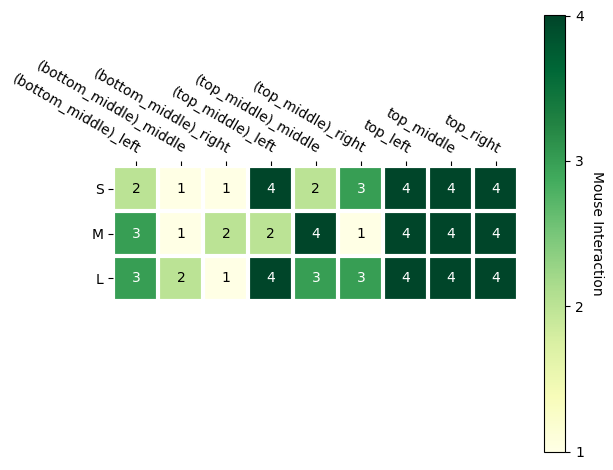

In [12]:
vegetables = ["S", "M", "L"]
farmers = my_dataz.index
harvest = np.array([S,
                    M,
                    L])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="Mouse Interaction")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.show()

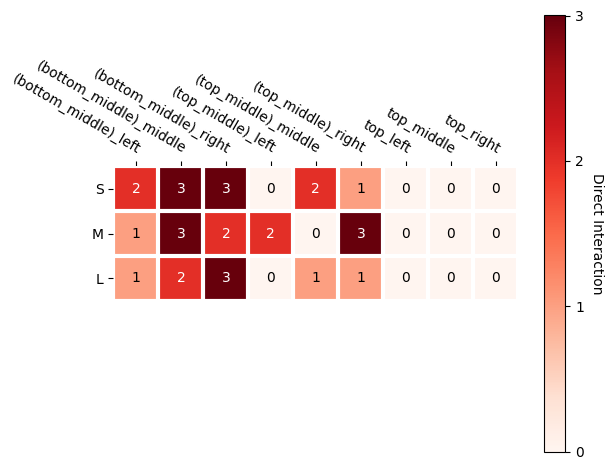

In [13]:
S = []
M = []
L = []
global_max = 0
for i in my_dataz.direct:
    S.append(i[0])
    M.append(i[1])
    L.append(i[2])
    my_local_max = np.maximum.reduce([S,M,L]).max()
    if my_local_max > global_max:
        global_max = my_local_max


vegetables = ["S", "M", "L"]
farmers = my_dataz.index
harvest = np.array([S,
                    M,
                    L])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="Reds", cbarlabel="Direct Interaction")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.show()

# 3- Model our data on Fitt's law

In [26]:
fitts_df = df.filter(regex= ("^time_[a-zA-Z0-9]*|test_nb|Fitts$"))

averages_of_time = pd.DataFrame(fitts_df.iloc[:,1:-1].mean(axis=1))

In [27]:
fitts_df

,test_nb,time_Maria,time_Mouad,time_Zainab,time_Yara,Fitts
0,26,4.479,0.594,2.041,1.198,0.281408
1,2,3.719,0.745,3.131,2.369,0.231870
2,20,1.864,0.608,1.997,1.719,0.340443
3,8,3.685,0.869,2.671,1.916,0.545538
4,1,3.850,4.090,3.824,2.912,0.583034
5,5,4.110,0.743,4.493,2.814,0.602608
6,13,3.977,0.960,2.239,1.860,0.583758
7,10,2.062,1.801,2.254,3.862,0.387606
8,25,2.939,1.228,2.675,1.994,0.449459
9,6,2.791,0.878,5.196,10.151,0.884903


In [31]:
averages_of_time.columns = ["averages_of_time"]
my_fitts_plotting_data = pd.concat((averages_of_time, fitts_df), axis=1).filter(["test_nb","averages_of_time", "Fitts"])

In [42]:
my_fitts_plotting_data.Fitts

0     0.281408
1     0.231870
2     0.340443
3     0.545538
4     0.583034
5     0.602608
6     0.583758
7     0.387606
8     0.449459
9     0.884903
10    0.401655
11    0.443377
12    0.616058
13    0.253638
14    0.539490
15    0.435072
16    0.441323
17    0.269608
18    0.859079
19    0.636476
20    0.415263
21    0.780541
22    0.612730
23    0.394234
24    0.923122
25    0.916280
26    0.466349
Name: Fitts, dtype: float64

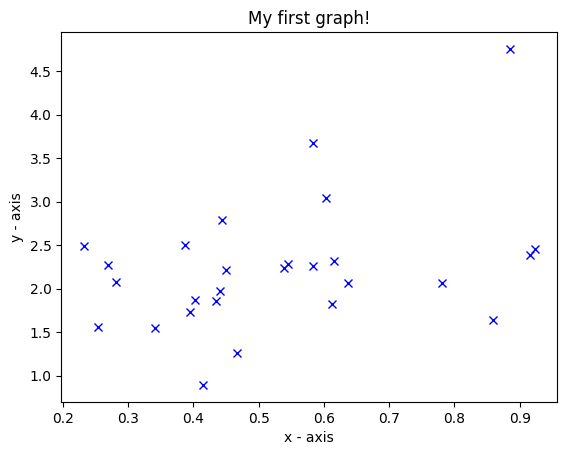

In [53]:
# x axis values 
x = my_fitts_plotting_data.Fitts
# corresponding y axis values 
y = my_fitts_plotting_data.averages_of_time
    
# plotting the points  
plt.plot(x, y, 'x', color='blue')
    
# naming the x axis 
plt.xlabel('x - axis') 
# naming the y axis 
plt.ylabel('y - axis') 
    
# giving a title to my graph 
plt.title('My first graph!') 
    
# function to show the plot 
plt.show() 